# Import Libraries

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Download Data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Plot Examples

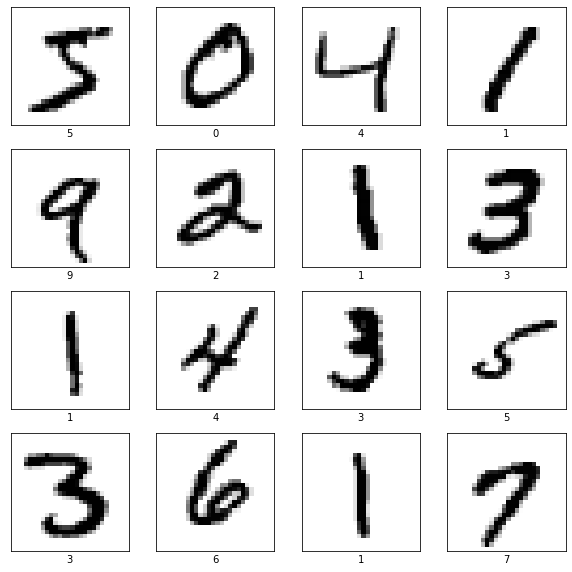

In [4]:
plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_train[i], cmap='binary')
    plt.xlabel(str(y_train[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

# Normalize Data

In [5]:
x_train = np.reshape(x_train, (60000, 784))
x_train = x_train / 255.

x_test = np.reshape(x_test, (10000, 784))
x_test = x_test / 255.

# Create a Neural Network Model

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='sigmoid', input_shape=(784,)),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Model

In [7]:
_ = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20, batch_size=1024,
    verbose=2
)

Epoch 1/20
59/59 - 1s - loss: 2.1929 - accuracy: 0.3055 - val_loss: 1.9886 - val_accuracy: 0.5563
Epoch 2/20
59/59 - 0s - loss: 1.7969 - accuracy: 0.6487 - val_loss: 1.5851 - val_accuracy: 0.7152
Epoch 3/20
59/59 - 0s - loss: 1.4069 - accuracy: 0.7442 - val_loss: 1.2221 - val_accuracy: 0.7863
Epoch 4/20
59/59 - 0s - loss: 1.0893 - accuracy: 0.8084 - val_loss: 0.9538 - val_accuracy: 0.8335
Epoch 5/20
59/59 - 0s - loss: 0.8627 - accuracy: 0.8454 - val_loss: 0.7655 - val_accuracy: 0.8660
Epoch 6/20
59/59 - 0s - loss: 0.7022 - accuracy: 0.8682 - val_loss: 0.6311 - val_accuracy: 0.8798
Epoch 7/20
59/59 - 0s - loss: 0.5873 - accuracy: 0.8822 - val_loss: 0.5362 - val_accuracy: 0.8900
Epoch 8/20
59/59 - 0s - loss: 0.5046 - accuracy: 0.8927 - val_loss: 0.4669 - val_accuracy: 0.8988
Epoch 9/20
59/59 - 0s - loss: 0.4446 - accuracy: 0.9010 - val_loss: 0.4166 - val_accuracy: 0.9057
Epoch 10/20
59/59 - 1s - loss: 0.3991 - accuracy: 0.9077 - val_loss: 0.3790 - val_accuracy: 0.9119
Epoch 11/20
59/59 -

# Save the Model

In [8]:
model.save('model.h5')

# The ML Server

In [11]:
%%writefile ml_server.py

import json
import tensorflow as tf
import numpy as np
import os
import random
import string

from flask import Flask, request

app = Flask(__name__)

model = tf.keras.models.load_model('model.h5')
feature_model = tf.keras.models.Model(model.inputs, [layer.output for layer in model.layers])

_, (x_test, _) = tf.keras.datasets.mnist.load_data()
x_test = x_test / 255.

def get_prediction():
    index = np.random.choice(x_test.shape[0])
    image = x_test[index,:,:]
    image_arr = np.reshape(image, (1, 784))
    return feature_model.predict(image_arr), image

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        preds, image = get_prediction()
        final_preds = [p.tolist() for p in preds]
        return json.dumps({'prediction': final_preds, 'image': image.tolist()})
    return 'Welcome to the ml server'

if __name__ == '__main__':
    app.run()


Overwriting ml_server.py


# Streamlit Web App

In [10]:
%%writefile app.py

import requests
import json
import numpy as np
import streamlit as st
import os
import matplotlib.pyplot as plt

URI = 'http://127.0.0.1:5000'

st.title('Neural Network Visualizer')
st.sidebar.markdown('# Input Image')

if st.button('Get random predictions'):
    response = requests.post(URI, data={})
    response = json.loads(response.text)
    preds = response.get('prediction')
    image = response.get('image')
    image = np.reshape(image, (28, 28))

    st.sidebar.image(image, width=150)

    for layer, p in enumerate(preds):
        numbers = np.squeeze(np.array(p))

        plt.figure(figsize=(32, 4))

        if layer == 2:
            row = 1
            col = 10
        else:
            row = 2
            col = 16

        for i, number in enumerate(numbers):
            plt.subplot(row, col, i + 1)
            plt.imshow((number * np.ones((8, 8, 3))).astype('float32'), cmap='binary')
            plt.xticks([])
            plt.yticks([])
            if layer == 2:
                plt.xlabel(str(i), fontsize=40)
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        plt.tight_layout()

        st.text('Layer {}'.format(layer + 1), )
        st.pyplot()


Writing app.py
